# Attribute Inference Metric Demo

This notebook demonstrates end‑to‑end usage of the **Attribute Inference (AI)** metric implemented in A4S.

The notebook demonstrates the following steps:
- Load and preprocess the Adult Census Income dataset (from Kaggle)
- Define A4S `DataShape` and `Dataset`
- Compute correlations between sensitive attributes and other features
- Train two victim models (Logistic Regression and a simple Neural Network)
- For each sensitive attribute (race, sex):
  - Train a model **with** all features
  - Train a model **without** that sensitive attribute's encoded columns
  - Run the A4S **attribute_inference** metric on held‑out test data
- Compare leakage across models and attributes


In [1]:
import numpy as np
import pandas as pd
import uuid
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from a4s_eval.data_model.evaluation import DataShape, Feature, FeatureType, Dataset
from a4s_eval.data_model.measure import Measure
from a4s_eval.metric_registries.model_metric_registry import model_metric_registry

plt.style.use("default")
sns.set(context="notebook", style="whitegrid")


## 1. Load & preprocess the Adult dataset

We use the Kaggle version of the **Adult Census Income** dataset stored at `data/adult.csv` (from https://www.kaggle.com/datasets/uciml/adult-census-income).

The Adult Census dataset is perfect for AI because it contains real demographic and socioeconomic attributes, including race and sex, which makes it realistic for studying leakage of sensitive information. The prediction target (income) is related to many features, which results in natural redundancies that make attribute inference possible even when the sensitive attribute is removed. 

In [2]:
df_raw = pd.read_csv("data/adult.csv")
print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
df = df_raw.copy()
for col in df.select_dtypes(include="object"):
    df[col] = df[col].str.strip()
df = df.replace("?", np.nan)
df = df.dropna().reset_index(drop=True)
print("After dropping rows with NaN:", df.shape)

df["income_binary"] = df["income"].str.contains(">50K").astype(int)

drop_cols = []
for col in df.columns:
    if df[col].isna().all() or df[col].nunique() <= 1:
        drop_cols.append(col)
if drop_cols:
    print("Dropping constant / all-null columns:", drop_cols)
    df = df.drop(columns=drop_cols)
df.head()


After dropping rows with NaN: (30162, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,income_binary
0,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,0
1,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,0
2,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,0
3,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K,0
4,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K,0


### 1.1 Select sensitive attributes


In [20]:
df["age_bucket"] = pd.cut(df["age"], bins=[0,25,40,60,120], labels=[0,1,2,3])

sensitive_attributes = ["race", "sex", "age_bucket"]
assert all(attr in df.columns for attr in sensitive_attributes)
df[sensitive_attributes].head()


,race,sex,age_bucket
0,White,Female,3
1,White,Female,2
2,White,Female,2
3,White,Female,1
4,White,Male,1


## 2. Encode features & compute correlations
Most features in the dataset are categorical strings and cannot be used directly by ML models or correlation analysis. I use one-hot encoding to avoid artificial ordering, and reveal correlations. Encoding is required both for model training and for measuring how sensitive attributes are embedded within other features.

In [21]:
target_col = "income_binary"
feature_cols_raw = [c for c in df.columns if c not in ["income", target_col]]
X_raw = df[feature_cols_raw]
y = df[target_col].values

cat_cols = X_raw.select_dtypes(include="object").columns.tolist()
num_cols = [c for c in X_raw.columns if c not in cat_cols]

X_encoded = pd.get_dummies(X_raw, columns=cat_cols, drop_first=True)
print("Encoded feature shape:", X_encoded.shape)
X_encoded.head()


Encoded feature shape: (30162, 97)


,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,age_bucket,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,82,132870,9,0,4356,18,3,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,54,140359,4,0,3900,40,2,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,41,264663,10,0,3900,40,2,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,34,216864,9,0,3770,45,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,38,150601,6,0,3770,40,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False



 Correlation analysis for: race

--- Category: race_Asian-Pac-Islander ---
Significant correlations: 8


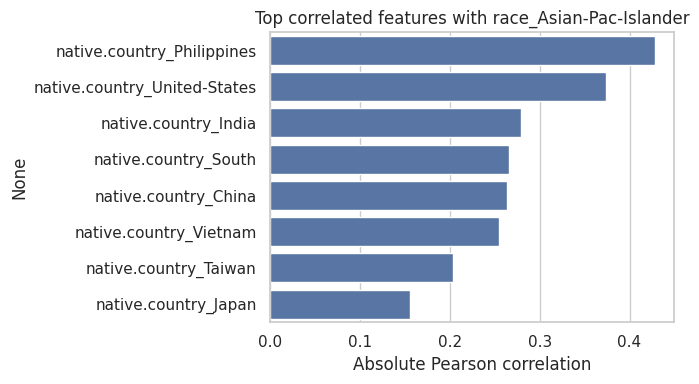


--- Category: race_Black ---
Significant correlations: 0
No correlations above threshold.

--- Category: race_Other ---
Significant correlations: 0
No correlations above threshold.

--- Category: race_White ---
Significant correlations: 2


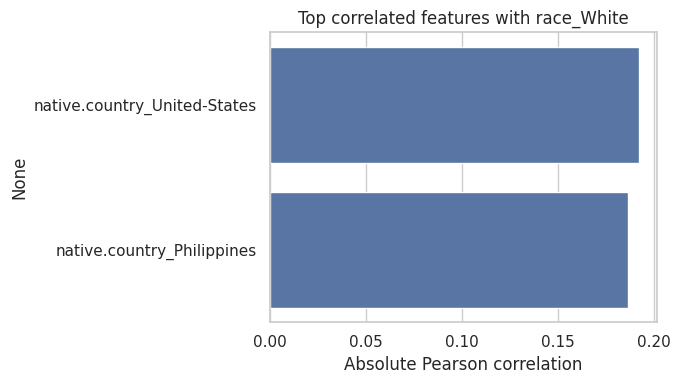


 Correlation analysis for: sex

--- Category: sex_Male ---
Significant correlations: 9


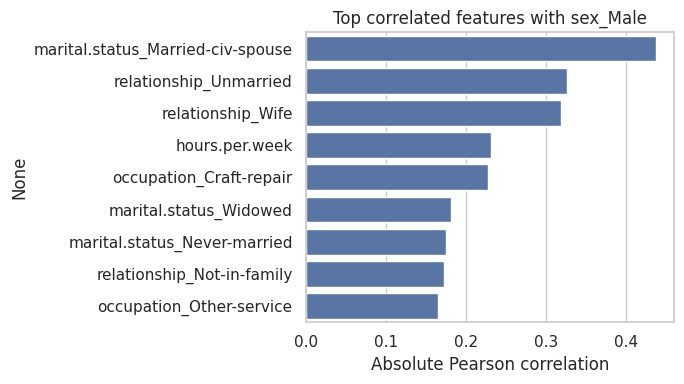


 Correlation analysis for: age_bucket
No one-hot columns found for attribute: age_bucket


In [22]:
def compute_categorywise_sensitive_correlations(df_encoded, sensitive_attributes, threshold=0.15):
    corr_results = {}
    for attr in sensitive_attributes:
        print(f"\n==============================")
        print(f" Correlation analysis for: {attr}")
        print("==============================")
        prefix = attr + "_"
        sensitive_cols = [c for c in df_encoded.columns if c.startswith(prefix)]
        if not sensitive_cols:
            print(f"No one-hot columns found for attribute: {attr}")
            continue
        non_sensitive_cols = [c for c in df_encoded.columns if c not in sensitive_cols]
        df_non_sensitive = df_encoded[non_sensitive_cols]
        for cat_col in sensitive_cols:
            print(f"\n--- Category: {cat_col} ---")
            s_cat = df_encoded[cat_col]
            df_corr = pd.concat([df_non_sensitive, s_cat.rename(cat_col)], axis=1)
            corrs = df_corr.corr()[cat_col].drop(cat_col)
            sig_corrs = corrs[corrs.abs() >= threshold].sort_values(key=lambda x: x.abs(), ascending=False)
            corr_results[cat_col] = sig_corrs
            print(f"Significant correlations: {len(sig_corrs)}")
            if sig_corrs.empty:
                print("No correlations above threshold.")
                continue
            plt.figure(figsize=(7, max(4, len(sig_corrs)*0.3)))
            sns.barplot(x=sig_corrs.abs().values, y=sig_corrs.index)
            plt.title(f"Top correlated features with {cat_col}")
            plt.xlabel("Absolute Pearson correlation")
            plt.tight_layout()
            plt.show()
    return corr_results

corr_results = compute_categorywise_sensitive_correlations(X_encoded, sensitive_attributes, threshold=0.15)


The correlations show how sensitive categories become statistically tied to other variables after encoding. 
We can see from the resulting graphs that race categories (unsurpisingly) align with specific native-country patterns. 
Similarly, sex aligns with marital-status and relationship labels. 

Although Pearson correlations may be small individually, the combined set of weak signals can still embed useful information for an attacker. These correlations show how sensitive attributes become indirectly encoded, even when they are not explicitly used.

## 3. Build A4S DataShape & Dataset
A4S expects models to expose a specific interface such as `predict_proba(x)`. Logistic Regression, neural networks, and models with removed features all require different preprocessing steps, including scaling and column selection. I use functional wrappers to ensure that every model is presented to the metric in a consistent way, independent of how it was trained or how its input is structured. 

In [23]:
df_for_metric = X_encoded.copy()
for attr in sensitive_attributes:
    df_for_metric[attr] = df[attr].values

feature_list = []
for col in X_encoded.columns:
    feature_list.append(
        Feature(
            pid=uuid.uuid4(),
            name=col,
            feature_type=FeatureType.FLOAT,
            min_value=None,
            max_value=None,
        )
    )

datashape = DataShape(
    features=feature_list,
    target=Feature(
        pid=uuid.uuid4(),
        name=target_col,
        feature_type=FeatureType.CATEGORICAL,
        min_value=None,
        max_value=None,
    ),
)

dataset_a4s = Dataset(
    pid=uuid.uuid4(),
    shape=datashape,
    data=df_for_metric,
)

datashape, dataset_a4s.data.head()


(DataShape(features=[Feature(pid=UUID('9e8001e3-022c-4069-a5db-ed812915da68'), name='age', feature_type=<FeatureType.FLOAT: 'float'>, min_value=None, max_value=None), Feature(pid=UUID('08ec3760-a2cd-42c8-a197-55fab0f58441'), name='fnlwgt', feature_type=<FeatureType.FLOAT: 'float'>, min_value=None, max_value=None), Feature(pid=UUID('be4d437e-5ec7-4bfa-b3dd-c30d8879974c'), name='education.num', feature_type=<FeatureType.FLOAT: 'float'>, min_value=None, max_value=None), Feature(pid=UUID('b0653d15-7ac3-40ab-a8d0-3837328a2847'), name='capital.gain', feature_type=<FeatureType.FLOAT: 'float'>, min_value=None, max_value=None), Feature(pid=UUID('05499d94-8c59-4ba3-8410-334f060f4b38'), name='capital.loss', feature_type=<FeatureType.FLOAT: 'float'>, min_value=None, max_value=None), Feature(pid=UUID('de318972-4d4a-4c50-8842-d5c00fe2cc6d'), name='hours.per.week', feature_type=<FeatureType.FLOAT: 'float'>, min_value=None, max_value=None), Feature(pid=UUID('e517faea-d049-49c8-a8ed-f27717f512ed'), nam

## 4. Train victim models (LR & NN)
I chose Logistic Regression (LR) and a simple Neural Network (NN) because LR provides a simple, interpretable baseline that reflects linear relationships in the data, while a small NN captures more complex nonlinear structure. 
Both are standard choices in privacy literature and allow us to test whether a more expressive model produces greater leakage. Using two different models helps determine whether attribute inference is a result of model capacity or inherent data correlations with the target output.

In [24]:
X = X_encoded.values
y_np = y.copy()
idx = np.arange(len(df))
train_idx, test_idx = train_test_split(idx, test_size=0.3, random_state=0, stratify=y_np)

X_train = X[train_idx]
X_test = X[test_idx]
y_train = y_np[train_idx]
y_test = y_np[test_idx]

scaler_all = StandardScaler()
X_train_scaled = scaler_all.fit_transform(X_train)
X_test_scaled = scaler_all.transform(X_test)

clf_lr_all = LogisticRegression(max_iter=1000, solver="saga", n_jobs=-1)
clf_lr_all.fit(X_train_scaled, y_train)
print("LR (all features) train acc:", clf_lr_all.score(X_train_scaled, y_train))
print("LR (all features) test  acc:", clf_lr_all.score(X_test_scaled, y_test))

clf_nn_all = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    max_iter=200,
    random_state=0,
    early_stopping=True,
)
clf_nn_all.fit(X_train_scaled, y_train)
print("NN (all features) train acc:", clf_nn_all.score(X_train_scaled, y_train))
print("NN (all features) test  acc:", clf_nn_all.score(X_test_scaled, y_test))


LR (all features) train acc: 0.8499976317908398
LR (all features) test  acc: 0.8455077909161234
NN (all features) train acc: 0.8628333254393028
NN (all features) test  acc: 0.8447342247762184


In [25]:
all_feature_names = X_encoded.columns.tolist()

class FM_LR_All:
    def predict_proba(self, x):
        x_scaled = scaler_all.transform(x)
        return clf_lr_all.predict_proba(x_scaled)

class FM_NN_All:
    def predict_proba(self, x):
        x_scaled = scaler_all.transform(x)
        return clf_nn_all.predict_proba(x_scaled)

fm_lr_all = FM_LR_All()
fm_nn_all = FM_NN_All()


## 5. Attribute inference experiments
For each sensitive attribute, we train a baseline model (for both LR and NN) using all features and a second model where the sensitive attribute’s encoded columns are removed. 
Comparing inference accuracy with and without the sensitive attribute tests whether the attribute is learned explicitly or via correlated features and whether removing it reduces leakage.


In [26]:
def columns_for_sensitive(attr: str):
    prefix = attr + "_"
    return [c for c in all_feature_names if c.startswith(prefix)]

attribute_inference_fn = model_metric_registry.get_functions()["attribute_inference"]
results = []

for attr in sensitive_attributes:
    print(f"\n=== Sensitive attribute: {attr} ===")
    encoded_cols = columns_for_sensitive(attr)

    # Handle numeric sensitive attributes (no one-hot encoded columns)
    if len(encoded_cols) == 0:
        if attr in all_feature_names:
            print(f"{attr} is numeric — treating raw column as sensitive.")
            encoded_cols = [attr]

    print("Encoded columns for", attr, ":", encoded_cols)
    kept_cols = [c for c in all_feature_names if c not in encoded_cols]
    kept_idx = [all_feature_names.index(c) for c in kept_cols]

    X_train_wo = X_train[:, kept_idx]
    X_test_wo = X_test[:, kept_idx]
    scaler_wo = StandardScaler()
    X_train_wo_scaled = scaler_wo.fit_transform(X_train_wo)
    X_test_wo_scaled = scaler_wo.transform(X_test_wo)

    clf_lr_wo = LogisticRegression(max_iter=2000, solver="saga", n_jobs=-1)
    clf_lr_wo.fit(X_train_wo_scaled, y_train)
    print("LR without", attr, "train acc:", clf_lr_wo.score(X_train_wo_scaled, y_train))
    print("LR without", attr, "test  acc:", clf_lr_wo.score(X_test_wo_scaled, y_test))

    clf_nn_wo = MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        max_iter=200,
        random_state=0,
        early_stopping=True,
    )
    clf_nn_wo.fit(X_train_wo_scaled, y_train)
    print("NN without", attr, "train acc:", clf_nn_wo.score(X_train_wo_scaled, y_train))
    print("NN without", attr, "test  acc:", clf_nn_wo.score(X_test_wo_scaled, y_test))

    class FM_LR_Without:
        def predict_proba(self, x):
            df_x = pd.DataFrame(x, columns=all_feature_names)
            x_wo = df_x[kept_cols].values
            x_wo_scaled = scaler_wo.transform(x_wo)
            return clf_lr_wo.predict_proba(x_wo_scaled)

    class FM_NN_Without:
        def predict_proba(self, x):
            df_x = pd.DataFrame(x, columns=all_feature_names)
            x_wo = df_x[kept_cols].values
            x_wo_scaled = scaler_wo.transform(x_wo)
            return clf_nn_wo.predict_proba(x_wo_scaled)

    fm_lr_wo = FM_LR_Without()
    fm_nn_wo = FM_NN_Without()

    df_attr = dataset_a4s.data.copy()
    if df[attr].dtype == object:
        cats = df[attr].astype("category").cat.categories
        mapping = {cat: i for i, cat in enumerate(cats)}
        df_attr["sensitive"] = df[attr].map(mapping)
    else:
        df_attr["sensitive"] = df[attr].values
    #df_attr = df_attr.rename(columns={attr: "sensitive"})
    df_attr_test = df_attr.iloc[test_idx].copy()

    dataset_attr = Dataset(
        pid=dataset_a4s.pid,
        shape=datashape,
        data=df_attr_test,
    )

    LR_with = attribute_inference_fn(datashape, None, dataset_attr, fm_lr_all)[0].score
    LR_without = attribute_inference_fn(datashape, None, dataset_attr, fm_lr_wo)[0].score
    NN_with = attribute_inference_fn(datashape, None, dataset_attr, fm_nn_all)[0].score
    NN_without = attribute_inference_fn(datashape, None, dataset_attr, fm_nn_wo)[0].score

    results.append({
        "sensitive_attribute": attr,
        "LR_with": LR_with,
        "LR_without": LR_without,
        "NN_with": NN_with,
        "NN_without": NN_without,
        "delta_LR": LR_with - LR_without,
        "delta_NN": NN_with - NN_without,
    })

results_df = pd.DataFrame(results)
results_df



=== Sensitive attribute: race ===
Encoded columns for race : ['race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White']
LR without race train acc: 0.8497134466916118
LR without race test  acc: 0.846502375953144
NN without race train acc: 0.8590915549661347
NN without race test  acc: 0.8471654326444911

=== Sensitive attribute: sex ===
Encoded columns for sex : ['sex_Male']
LR without sex train acc: 0.8497608108748165
LR without sex test  acc: 0.8459498287103547
NN without sex train acc: 0.8751480130725146
NN without sex test  acc: 0.8438501491877556

=== Sensitive attribute: age_bucket ===
age_bucket is numeric — treating raw column as sensitive.
Encoded columns for age_bucket : ['age_bucket']
LR without age_bucket train acc: 0.850234452706863
LR without age_bucket test  acc: 0.8460603381589126
NN without age_bucket train acc: 0.8620754985080282
NN without age_bucket test  acc: 0.8462813570560282


,sensitive_attribute,LR_with,LR_without,NN_with,NN_without,delta_LR,delta_NN
0,race,0.859669,0.859669,0.859669,0.859669,0.000000,0.000000
1,sex,0.673665,0.673665,0.673665,0.673665,0.000000,0.000000
2,age_bucket,0.494659,0.474401,0.533333,0.520810,0.020258,0.012523


## 6. Visualize attribute inference leakage


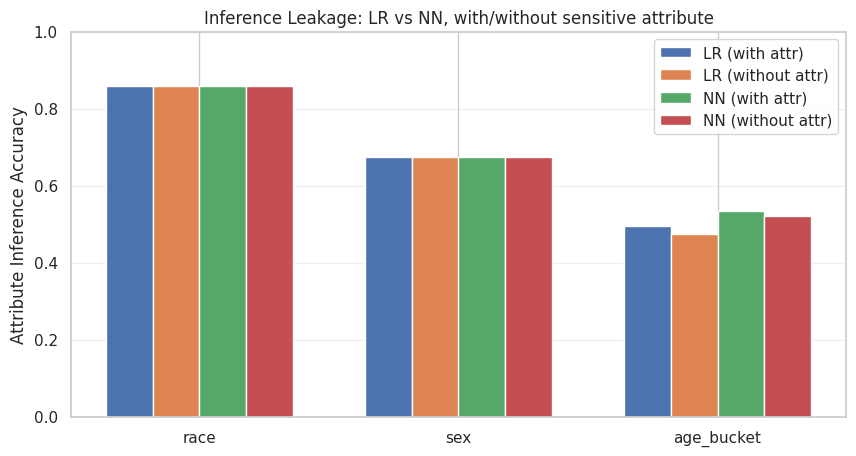

,sensitive_attribute,LR_with,LR_without,NN_with,NN_without,delta_LR,delta_NN
0,race,0.859669,0.859669,0.859669,0.859669,0.000000,0.000000
1,sex,0.673665,0.673665,0.673665,0.673665,0.000000,0.000000
2,age_bucket,0.494659,0.474401,0.533333,0.520810,0.020258,0.012523


In [27]:
plt.figure(figsize=(10, 5))
x_pos = np.arange(len(results_df))
width = 0.18
plt.bar(x_pos - 1.5*width, results_df["LR_with"], width=width, label="LR (with attr)")
plt.bar(x_pos - 0.5*width, results_df["LR_without"], width=width, label="LR (without attr)")
plt.bar(x_pos + 0.5*width, results_df["NN_with"], width=width, label="NN (with attr)")
plt.bar(x_pos + 1.5*width, results_df["NN_without"], width=width, label="NN (without attr)")
plt.xticks(x_pos, results_df["sensitive_attribute"])
plt.ylabel("Attribute Inference Accuracy")
plt.title("Inference Leakage: LR vs NN, with/without sensitive attribute")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()
results_df


The plot shows that attribute inference across the different settings (choice of model, presence of attribute) are the same for both sensitive attributes. It is also clear that the attacker model was able to infer both attributes but especially race with a very high accuracy.

There are a few things that struck me about these results, that I investigated further:

**1. Why is delta_LR = delta_NN = 0?**

The fact that the delta values are exactly zero indicates that removing the sensitive attribute from the model’s training features does not reduce the attacker’s ability to infer that attribute from the model’s output. 
In turn, this means that the sensitive attribute is not the only source of the leaked information. Other features, which are statistically correlated with the sensitive attribute, still encode enough information for the attacker to reconstruct it with the same accuracy. In the Adult dataset, attributes such as native-country, relationship, marital-status, and occupation carry demographic patterns that strongly overlap with race and sex. As a result, the model’s output distribution remains essentially unchanged even when the explicit sensitive attribute is removed, and the attacker sees no meaningful difference. 
This demonstrates a core challenge in privacy-preserving ML: simply omitting a sensitive attribute does not eliminate the sensitive information, because it is redundantly encoded in other features.

**2. Why is AI for race high despite low Pearson correlation?**

Although Pearson correlation between individual features and race categories is relatively small (see part 2), the attacker relies on the joint structure of many features simultaneously. The one-hot encoded version of the dataset contains numerous variables related to native-country, relationship status, occupation, and education. Even if each variable has only a weak correlation with race, the multivariate combination seems to form distinctive patterns that reveal substantial demographic structure. 
These patterns produce different distributions of model outputs for different racial groups. The model trained to predict income tends to assign systematically higher probabilities for Asian-Pac-Islander individuals and lower probabilities for Black individuals, with White individuals occupying the middle range. 
This separation in output distributions allows the attribute inference attacker, even with a simple logistic regression, to reconstruct race with high accuracy. The key insight is that low pairwise correlations do not imply low information leakage; when many weak signals point in the same direction, the combination becomes highly predictive.

**3. Why does age (in buckets) leak less than race or sex?**

The results for `age_bucket` show noticeably lower attribute-inference accuracy compared to race and sex, indicating that age is not as strongly encoded in the other features of the Adult dataset. Unlike demographic attributes such as race and sex, age does not have as many strong or consistent proxies. As a result, when age is removed, the model’s outputs carry far less information about it, and the attacker’s accuracy drops close to chance levels. This suggests that age is less intrinsically entangled with other features, making it substantially harder to infer from the model’s predictions alone.
